## Neural network workflow

This notebook describes the workflow for training neural networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor

import numpy as np
from scipy.io import loadmat

from dstools import plot

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [3]:
# for reference
print('YASS version is: {}'.format(util.get_version()))

YASS version is: 453b207 option for saving and loading test set


In [4]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
spike_train = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
spike_train = spike_train[2:-1]

# shift ids to start at 0
spike_train[:, 1] = spike_train[:, 1] - 1

# compensate alignment
spike_train[:, 0] = spike_train[:, 0] + 10

In [7]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

## Visualizing templates

In [8]:
# use all templates
n_templates = np.max(spike_train[:,1]) + 1
chosen_templates_indexes = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [9]:
# load 4x templates
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train,
                                                path_to_standarized)

processor.choose_with_indexes(chosen_templates_indexes, inplace=True)
processor.choose_with_minimum_amplitude(4, inplace=True)

templates_uncropped = processor.templates

processor.align(CONFIG.spike_size, inplace=True)
templates = (processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
             .values)

100%|██████████| 3/3 [00:15<00:00,  5.01s/it]


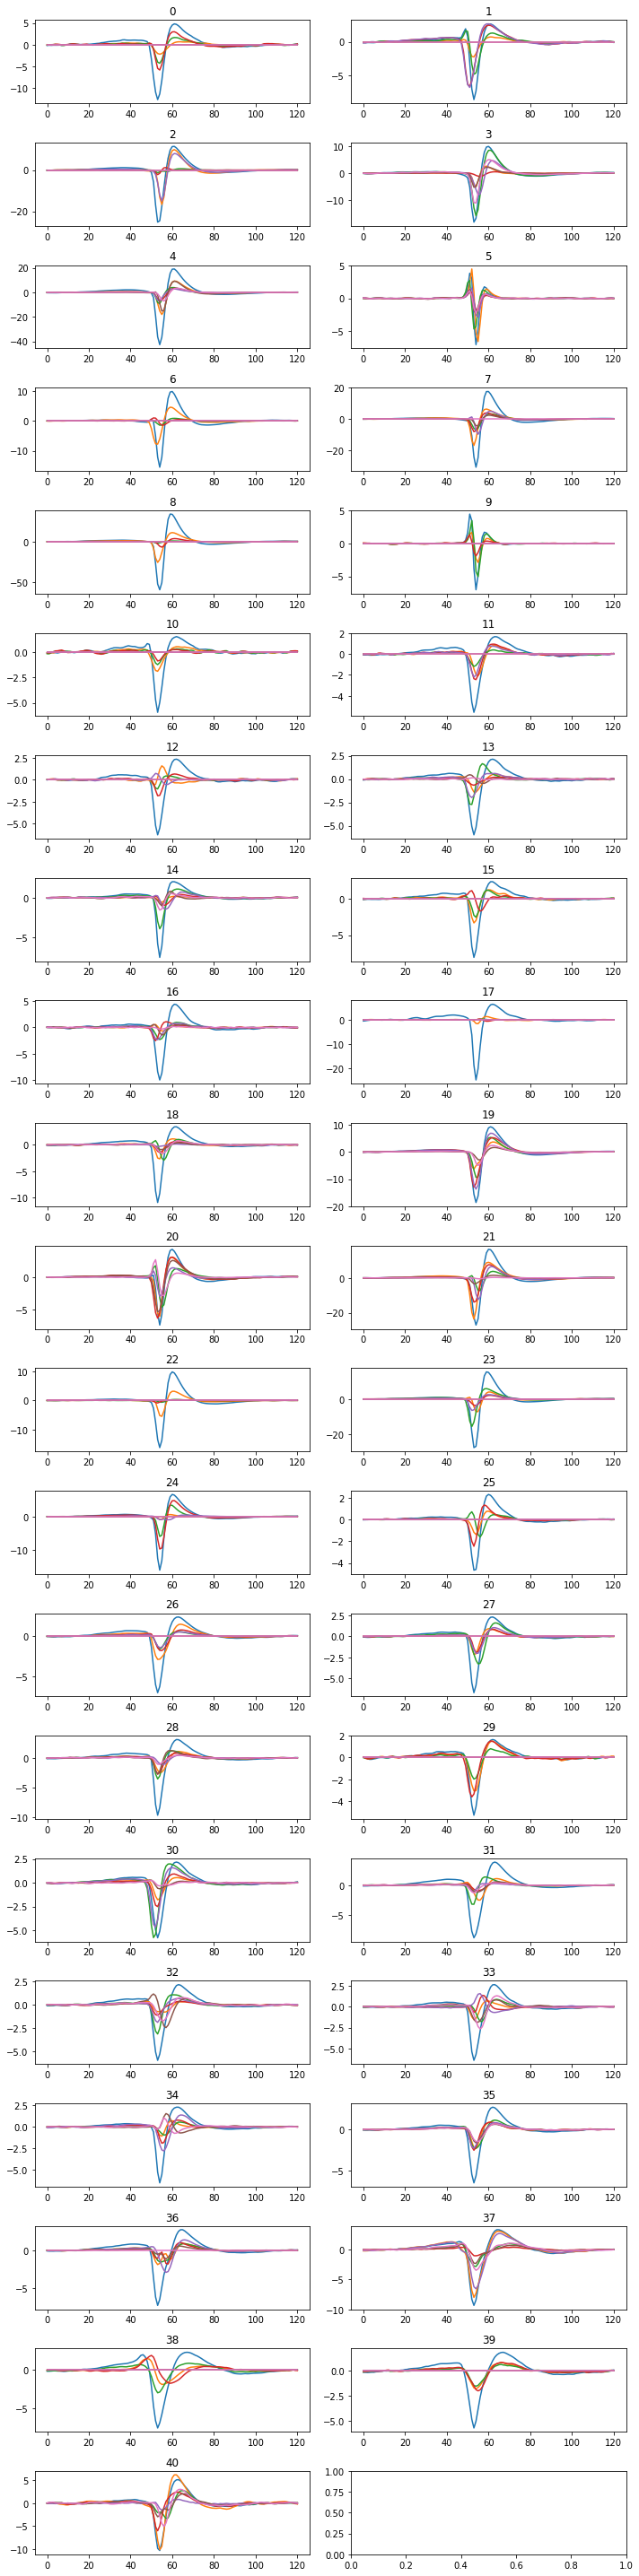

In [10]:
# this is just a handy plotting function, you don't actually
# need it
plot.grid_from_array(templates, axis=0, figsize=(10, 40),
                     max_cols=2)

## Generating training data

In [38]:
n_spikes = 20000
min_amplitude = 3
max_amp = 10
noise_ratio = 2
multi_channel = True

In [39]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, spike_train,
                                  chosen_templates_indexes,
                                  min_amplitude, max_amp, n_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True,
                                  noise_ratio=noise_ratio)


100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


In [40]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(100040, 41, 7)
	triage:(40016, 41, 7)
	autoencoder:(195200, 41)


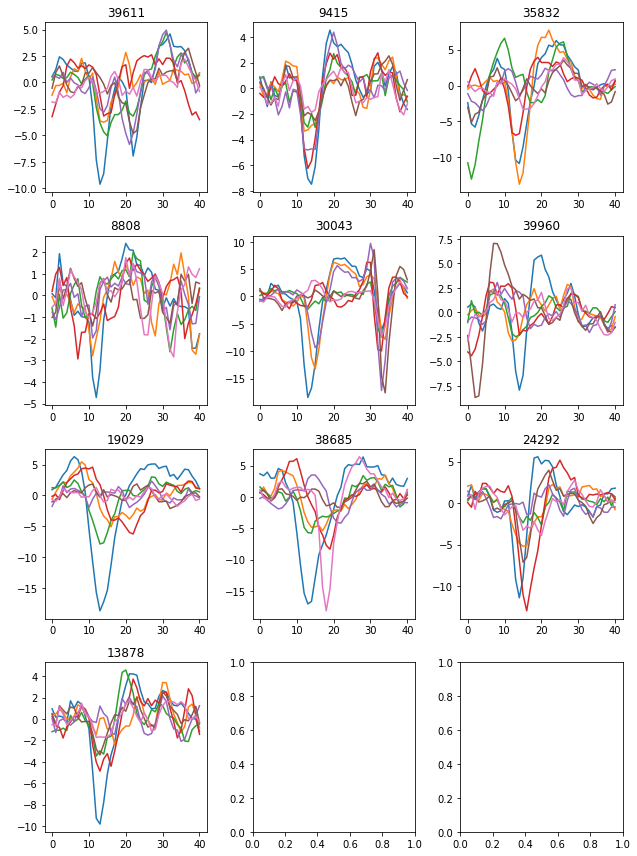

In [35]:
plot.grid_from_array(x_detect[y_detect == 1], axis=0,
                     elements=10,
                     auto_figsize=3)

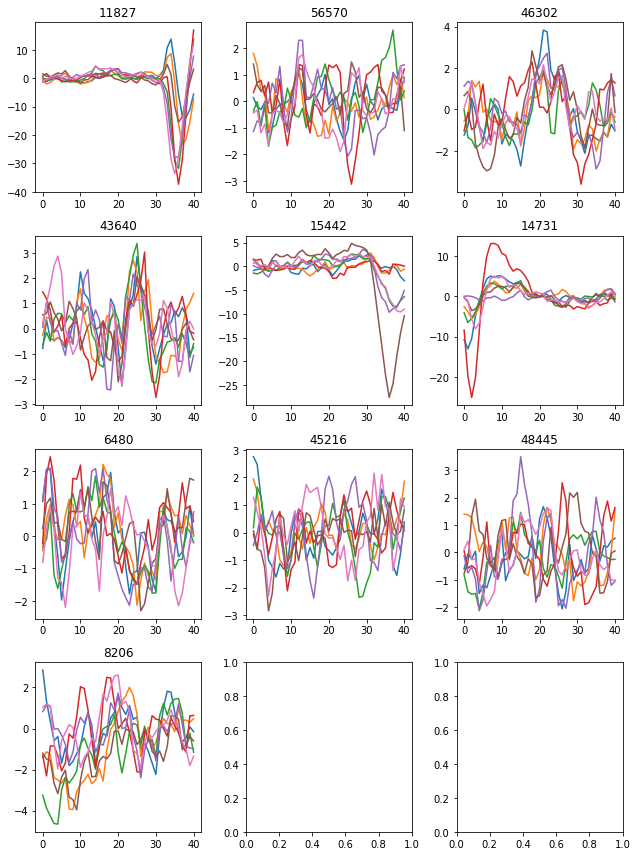

In [15]:
plot.grid_from_array(x_detect[y_detect == 0], axis=0,
                     elements=10,
                     auto_figsize=3)

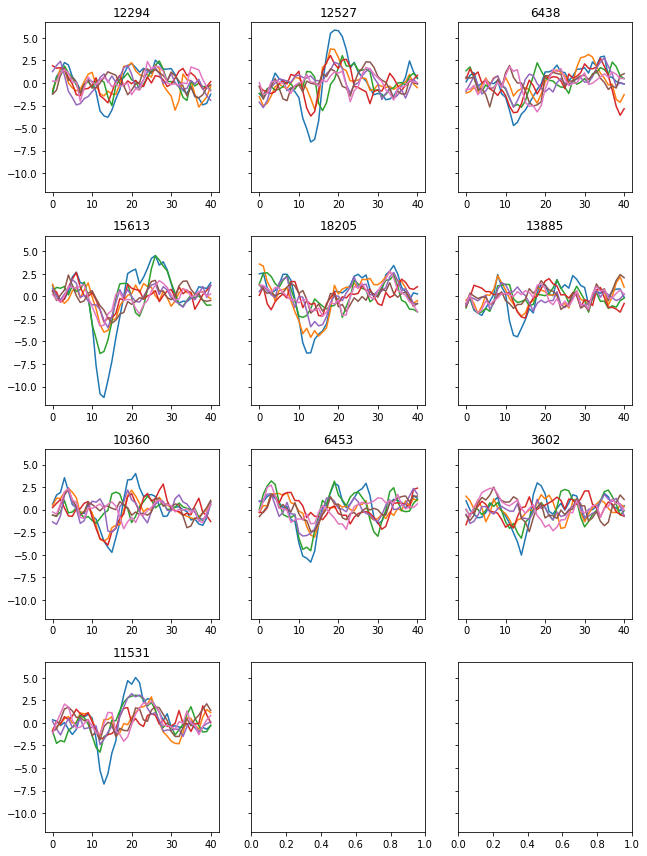

In [41]:
plot.grid_from_array(x_triage[y_triage == 1], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

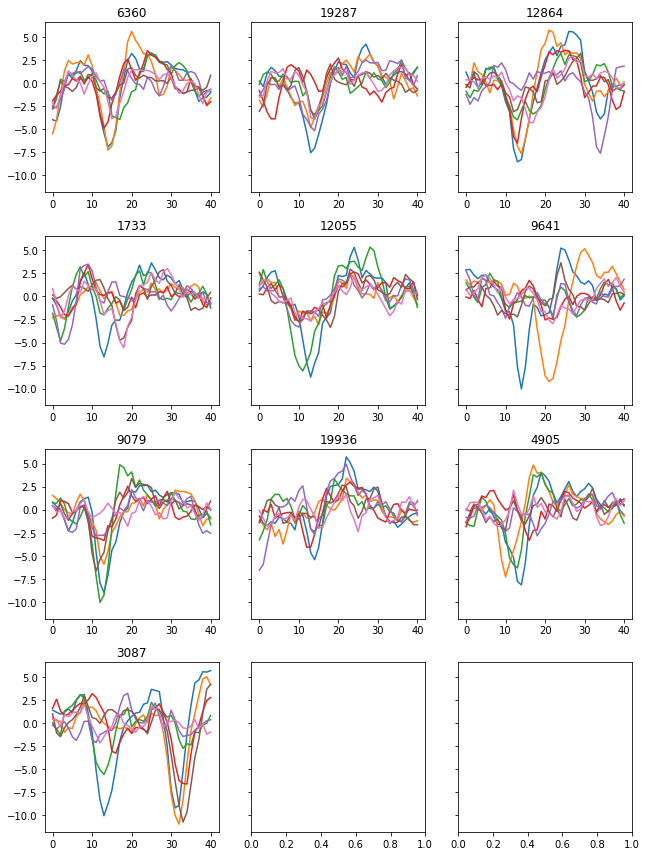

In [42]:
plot.grid_from_array(x_triage[y_triage == 0], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

# Training

In [52]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001
filters_detect = [32, 16]

path_to_models = path.join(path_to_here, 'models')

## Detector training

In [44]:
detect_name = path.join(path_to_models, 'detect',
                        filename('ckpt'))

print('Training {}...'.format(detect_name))

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

Training /home/Edu/dev/private-yass/nnet/models/detect/27-Jul-2018@13-14-03.ckpt...



Tr loss: 0.023465225, Val loss: 0.03329179:  20%|██        | 1006/5000 [00:08<00:32, 121.93it/s]


Tr loss: 0.020902433, Val loss: 0.026914923:  40%|███▉      | 1989/5000 [00:15<00:24, 124.35it/s]


Tr loss: 0.010814804, Val loss: 0.026670381:  53%|█████▎    | 2665/5000 [00:21<00:18, 125.39it/s]

KeyboardInterrupt: 

## Triage training

In [53]:
triage_name = path.join(path_to_models, 'triage', filename('ckpt'))
filters_triage = [32, 16]

In [54]:
print('Training {}...'.format(triage_name))

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage, save_test_set=True)

Training /home/Edu/dev/private-yass/nnet/models/triage/27-Jul-2018@13-34-33.ckpt...




  0%|          | 0/5000 [00:00<?, ?it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   0%|          | 0/5000 [00:00<?, ?it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   0%|          | 1/5000 [00:00<1:04:20,  1.30it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   0%|          | 13/5000 [00:00<05:36, 14.84it/s] 

Tr loss: 0.70513374, Val loss: 0.6948706:   0%|          | 25/5000 [00:00<03:14, 25.55it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   1%|          | 37/5000 [00:01<02:24, 34.24it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   1%|          | 49/5000 [00:01<01:59, 41.44it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   1%|          | 61/5000 [00:01<01:43, 47.51it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   1%|▏         | 73/5000 [00:01<01:33, 52.66it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   2%|▏         | 85/5000 [00:01<01:26, 57.11it/s]

Tr loss: 0.70513374, Val loss: 0.6948706:   2%|▏         | 97/5000 [00:01<01:20, 60.94it/s]

Tr loss: 0.5654806, Val loss: 0.5

Tr loss: 0.3187147, Val loss: 0.3304529:  17%|█▋        | 865/5000 [00:08<00:39, 103.63it/s]

Tr loss: 0.3187147, Val loss: 0.3304529:  18%|█▊        | 877/5000 [00:08<00:39, 103.79it/s]

Tr loss: 0.3187147, Val loss: 0.3304529:  18%|█▊        | 889/5000 [00:08<00:39, 103.95it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  18%|█▊        | 889/5000 [00:08<00:40, 102.59it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  18%|█▊        | 901/5000 [00:08<00:39, 103.96it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  18%|█▊        | 913/5000 [00:08<00:39, 104.09it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  18%|█▊        | 925/5000 [00:08<00:39, 104.22it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  19%|█▊        | 937/5000 [00:08<00:38, 104.37it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  19%|█▉        | 949/5000 [00:09<00:38, 104.51it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  19%|█▉        | 961/5000 [00:09<00:38, 104.65it/s]

Tr loss: 0.35739172, Val loss: 0.3194873:  19%|█▉    

Tr loss: 0.24029264, Val loss: 0.28624934:  34%|███▍      | 1717/5000 [00:15<00:30, 107.93it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  35%|███▍      | 1729/5000 [00:16<00:30, 107.97it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  35%|███▍      | 1741/5000 [00:16<00:30, 108.01it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  35%|███▌      | 1753/5000 [00:16<00:30, 108.03it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  35%|███▌      | 1765/5000 [00:16<00:29, 108.06it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  36%|███▌      | 1777/5000 [00:16<00:29, 108.10it/s]

Tr loss: 0.24029264, Val loss: 0.28624934:  36%|███▌      | 1789/5000 [00:16<00:29, 108.12it/s]

Tr loss: 0.28370398, Val loss: 0.2869445:  36%|███▌      | 1789/5000 [00:16<00:29, 107.34it/s] 

Tr loss: 0.28370398, Val loss: 0.2869445:  36%|███▌      | 1801/5000 [00:16<00:29, 108.05it/s]

Tr loss: 0.28370398, Val loss: 0.2869445:  36%|███▋      | 1813/5000 [00:16<00:29, 108.08it/s]

Tr loss: 0.28370398, Val loss: 0

Tr loss: 0.21996014, Val loss: 0.27638978:  51%|█████▏    | 2571/5000 [00:23<00:22, 109.42it/s]

Tr loss: 0.21996014, Val loss: 0.27638978:  52%|█████▏    | 2583/5000 [00:23<00:22, 109.43it/s]

Tr loss: 0.21996014, Val loss: 0.27638978:  52%|█████▏    | 2595/5000 [00:23<00:21, 109.44it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  52%|█████▏    | 2595/5000 [00:23<00:22, 109.12it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  52%|█████▏    | 2607/5000 [00:23<00:21, 109.38it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  52%|█████▏    | 2619/5000 [00:23<00:21, 109.38it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  53%|█████▎    | 2631/5000 [00:24<00:21, 109.40it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  53%|█████▎    | 2643/5000 [00:24<00:21, 109.42it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  53%|█████▎    | 2655/5000 [00:24<00:21, 109.44it/s]

Tr loss: 0.26292253, Val loss: 0.27461874:  53%|█████▎    | 2667/5000 [00:24<00:21, 109.45it/s]

Tr loss: 0.26292253, Val loss:

Tr loss: 0.24012281, Val loss: 0.27437288:  68%|██████▊   | 3411/5000 [00:31<00:14, 109.79it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  68%|██████▊   | 3423/5000 [00:31<00:14, 109.80it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  69%|██████▊   | 3435/5000 [00:31<00:14, 109.82it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  69%|██████▉   | 3447/5000 [00:31<00:14, 109.83it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  69%|██████▉   | 3459/5000 [00:31<00:14, 109.84it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  69%|██████▉   | 3471/5000 [00:31<00:13, 109.85it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  70%|██████▉   | 3483/5000 [00:31<00:13, 109.87it/s]

Tr loss: 0.24012281, Val loss: 0.27437288:  70%|██████▉   | 3495/5000 [00:31<00:13, 109.87it/s]

Tr loss: 0.23050018, Val loss: 0.2737552:  70%|██████▉   | 3495/5000 [00:31<00:13, 109.65it/s] 

Tr loss: 0.23050018, Val loss: 0.2737552:  70%|███████   | 3507/5000 [00:31<00:13, 109.84it/s]

Tr loss: 0.23050018, Val loss: 

Tr loss: 0.17264892, Val loss: 0.27072105:  85%|████████▌ | 4263/5000 [00:38<00:06, 110.44it/s]

Tr loss: 0.17264892, Val loss: 0.27072105:  86%|████████▌ | 4275/5000 [00:38<00:06, 110.45it/s]

Tr loss: 0.17264892, Val loss: 0.27072105:  86%|████████▌ | 4287/5000 [00:38<00:06, 110.47it/s]

Tr loss: 0.17264892, Val loss: 0.27072105:  86%|████████▌ | 4299/5000 [00:38<00:06, 110.49it/s]

Tr loss: 0.18885675, Val loss: 0.2721636:  86%|████████▌ | 4299/5000 [00:38<00:06, 110.40it/s] 

Tr loss: 0.18885675, Val loss: 0.2721636:  86%|████████▌ | 4311/5000 [00:39<00:06, 110.47it/s]

Tr loss: 0.18885675, Val loss: 0.2721636:  86%|████████▋ | 4323/5000 [00:39<00:06, 110.48it/s]

Tr loss: 0.18885675, Val loss: 0.2721636:  87%|████████▋ | 4335/5000 [00:39<00:06, 110.50it/s]

Tr loss: 0.18885675, Val loss: 0.2721636:  87%|████████▋ | 4347/5000 [00:39<00:05, 110.52it/s]

Tr loss: 0.18885675, Val loss: 0.2721636:  87%|████████▋ | 4359/5000 [00:39<00:05, 110.54it/s]

Tr loss: 0.18885675, Val loss: 0.27

{'filters_size': [32, 16],
 'waveform_length': 41,
 'n_neighbors': 7,
 'name': '27-Jul-2018@13-34-33',
 'tn': 0.857190635451505,
 'fp': 0.14174273858921163,
 'fn': 0.08277591973244147,
 'tp': 0.9178423236514522,
 'acc': 0.8876301541024573,
 'prec': 0.8662280701754386,
 'rec': 0.9178423236514522,
 'metadata': {'yass_version': '96796f6 fixes slice creation'}}

In [47]:
! cat /home/Edu/dev/private-yass/nnet/models/triage/27-Jul-2018@13-14-29.yaml

acc: !!python/object/apply:numpy.core.multiarray.scalar
- &id001 !!python/object/apply:numpy.dtype
  args: [f8, 0, 1]
  state: !!python/tuple [3, <, null, null, null, -1, -1, 0]
- !!binary |
  0XUPz6p+7D8=
filters_size: [32, 16]
fn: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  rwuUSQrTqT8=
fp: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  UstWmtSyxT8=
metadata: {yass_version: 96796f6 fixes slice creation}
n_neighbors: 7
name: 27-Jul-2018@13-14-29
prec: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  hRJyoTom6z8=
rec: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  jXK5RqNc7j8=
tn: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  hNF1P7un6j8=
tp: !!python/object/apply:numpy.core.multiarray.scalar
- *id001
- !!binary |
  jXK5RqNc7j8=
waveform_length: 41


## Autoencoder training

In [19]:
ae_name = path.join(path_to_here, 'models', 'ae', filename('ckpt'))

_, waveform_length = x_ae.shape

encoder = AutoEncoder(ae_name, waveform_length, n_features=3)
encoder.fit(x_ae)

# Using trained models

Once the model is trained it can be used in the pipeline by specifying
it in the YASS config file but it can also be used separately, see
the documentation for more info.

**Note on backwards compatibility: models trained with the new module are compatible with old versions of YASS, the only thing that needs to be
changed are the keys in the generated .yaml file**